<a href="https://colab.research.google.com/github/njucs/notebook/blob/master/FirstTry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **准备工作**

import 导入模块，每次使用模块中的函数都要是定是哪个模块。 from … import * 导入模块，每次使用模块中的函数，直接使用函数就可以了；注因为已经知道该函数是那个模块中的了。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision as tv
from torchvision import models,transforms,datasets

### **一些小技巧**

In [30]:
# 查看Python解释器
import sys
print(sys.executable)

# 测试GPU是否可用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())
use_gpu = torch.cuda.is_available()

# 把Tensor转成Image，方便可视化
'''
from torchvision.transforms import ToPILImage
show = ToPILImage()

x = torch.randn(300,500)
show(x)#.resize((100, 100))
'''

/usr/bin/python3
Using gpu: True 


### **数据加载和预处理**
**Dataset**对象是一个数据集，可以按下标访问，返回形如(data, label)的数据。

**Dataloader**是一个可迭代的对象，它将dataset返回的每一条数据拼接成一个batch，并提供多线程加速优化和数据打乱等操作。当程序对dataset的所有数据遍历完一遍之后，相应的对Dataloader也完成了一次迭代。

In [4]:
import torchvision.transforms as transforms

# 定义对数据的预处理
transform = transforms.Compose([
        transforms.ToTensor(), # 转为Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 归一化
                             ])

# 训练集
trainset = tv.datasets.CIFAR10(
                    root='./data/tmp/', 
                    train=True, 
                    download=True,
                    transform=transform)

trainloader = torch.utils.data.DataLoader(
                    trainset, 
                    batch_size=4,
                    shuffle=True, 
                    num_workers=2)

# 测试集
testset = tv.datasets.CIFAR10(
                    './data/tmp/',
                    train=False, 
                    download=True, 
                    transform=transform)

testloader = torch.utils.data.DataLoader(
                    testset,
                    batch_size=4, 
                    shuffle=False,
                    num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/tmp/cifar-10-python.tar.gz to ./data/tmp/
Files already downloaded and verified


      truck        deer         car        frog


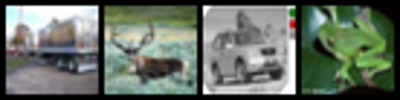

In [5]:
# 可以查看一下部分数据内容
'''
dataiter = iter(trainloader)
images, labels = dataiter.next() # 返回4张图片及标签
print(' '.join('%11s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid((images + 1) / 2)).resize((400,100))
#show(images[2]).resize((100,100))
'''

### **定义网络**
定义网络时，需要继承nn.Module，并实现它的forward方法，**把网络中具有可学习参数的层放在构造函数\__init__中**。如果某一层(如ReLU)不具有可学习的参数，则既可以放在构造函数中，也可以不放，但建议不放在其中，而在forward中使用nn.functional代替。

**只要在nn.Module的子类中定义了forward函数，backward函数就会自动被实现(利用autograd)**。在forward 函数中可使用任何tensor支持的函数，还可以使用if、for循环、print、log等Python语法，写法和标准的Python写法一致。

torch.nn只支持mini-batches，不支持一次只输入一个样本，即一次必须是一个batch。但如果只想输入一个样本，则用 input.unsqueeze(0)将batch_size设为１。即输入必须是N个samples，但N可以设为1。

In [24]:
class Net(nn.Module):
    def __init__(self):
        # nn.Module子类的函数必须在构造函数中执行父类的构造函数
        # 下式等价于nn.Module.__init__(self)
        super(Net, self).__init__()
        
        # 卷积层
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # 全连接层
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # reshape，‘-1’表示自适应
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

if(use_gpu):
    net = net.cuda()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### **查看网络的可学习参数**

网络的可学习参数通过net.parameters()返回，net.named_parameters可同时返回可学习的参数及名称。

In [25]:
params = list(net.parameters())
print(params)

for name,parameters in net.named_parameters():
    print(name,':',parameters.size())

[Parameter containing:
tensor([[[[-6.0722e-02,  8.7142e-02,  5.5034e-02, -8.0920e-02,  7.2283e-03],
          [-2.5723e-02,  8.5890e-02, -5.7417e-02, -1.0332e-01, -9.8110e-02],
          [ 1.0056e-01,  1.2063e-02, -9.6765e-02, -1.1531e-01, -8.5094e-02],
          [ 4.3057e-02, -1.1014e-01, -7.6221e-03,  1.3396e-02, -4.0626e-02],
          [-6.3424e-02,  7.4969e-02, -7.8656e-02, -4.4806e-02,  8.6407e-02]],

         [[-3.0541e-02, -1.0092e-01, -9.9098e-02, -2.3333e-02,  1.9735e-02],
          [ 1.1326e-01, -7.3900e-02,  4.6933e-03, -2.5288e-02,  5.3641e-04],
          [-6.5722e-02, -3.9251e-02, -8.7817e-02,  8.6999e-02,  1.2598e-02],
          [ 1.1276e-01, -2.3396e-02, -1.0499e-01, -7.5159e-02, -3.6502e-02],
          [ 8.9721e-02,  9.8928e-02, -8.7125e-02,  9.4294e-02,  1.0464e-01]],

         [[-6.9894e-02, -5.6818e-02, -1.0478e-01, -8.1985e-02, -6.9451e-02],
          [-1.7368e-02, -9.9657e-02, -1.3552e-03,  5.7715e-02, -7.0573e-03],
          [-4.8722e-02,  6.4531e-02, -2.4436e-02,

### **定义损失函数和优化器**

In [26]:
# 损失函数
criterion = nn.CrossEntropyLoss()
'''
criterion = nn.MSELoss() # 均方误差损失, 计算 output 和 target 之差的均方差.
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数, 描述两个概率分布的差异, 当训练有 C 个类别的分类问题时很有效.
criterion = nn.KLDivLoss() # 计算 input 和 target 之间的 KL 散度. KL 散度可用于衡量不同的连续分布之间的距离, 在连续的输出分布的空间上(离散采样)上进行直接回归时很有效.
criterion = nn.BCELoss() # 二进制交叉熵损失 BCELoss. 二分类任务时的交叉熵计算函数. 注意目标的值的范围为0到1之间.
criterion = nn.MultiLabelMarginLoss() # 多标签分类损失 MultiLabelMarginLoss
criterion = nn.MultiLabelSoftMarginLoss() # 多标签 one-versus-all 损失
criterion = nn.CosineEmbeddingLoss() # cosine 损失
criterion = nn.MultiMarginLoss(p=1, margin=1.0) # 多类别分类的hinge损失
criterion = nn.TripletMarginLoss(margin=1.0, p=2.0, eps=1e-06, swap=False, reduction='mean') # 三元组损失
criterion = nn.NLLLoss() # 负对数似然损失. 用于训练 C 个类别的分类问题.
'''

# 优化器
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
'''
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adagrad(net.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0) # 一种自适应优化方法，是自适应的为各个参数分配不同的学习率
optimizer = optim.RMSprop(net.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False) # 对Adagrad的一种改进，可缓解Adagrad学习率下降较快的问题
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False) # 结合了Momentum和RMSprop，并进行了偏差修正
'''

if(use_gpu):
    criterion = criterion.cuda()

### **训练网络并更新网络参数**

所有网络的训练流程都是类似的，不断地执行如下流程：

1. 输入数据
2. 前向传播+反向传播
3. 更新参数

In [27]:
torch.set_num_threads(8)
for epoch in range(20):  
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # 输入数据
        inputs, labels = data
        if(use_gpu):
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        # 梯度清零
        optimizer.zero_grad()
        
        # forward + backward 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()   
        
        # 更新参数 
        optimizer.step()
        
        # 打印log信息
        # loss 是一个scalar,需要使用loss.item()来获取数值，不能使用loss[0]
        running_loss += loss.item()
        if i % 2000 == 1999: # 每2000个batch打印一下训练状态
            print('[%d, %5d] loss: %.3f' \
                  % (epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.212
[1,  4000] loss: 1.849
[1,  6000] loss: 1.678
[1,  8000] loss: 1.564
[1, 10000] loss: 1.526
[1, 12000] loss: 1.469
[2,  2000] loss: 1.403
[2,  4000] loss: 1.372
[2,  6000] loss: 1.325
[2,  8000] loss: 1.337
[2, 10000] loss: 1.310
[2, 12000] loss: 1.309
[3,  2000] loss: 1.210
[3,  4000] loss: 1.223
[3,  6000] loss: 1.210
[3,  8000] loss: 1.202
[3, 10000] loss: 1.173
[3, 12000] loss: 1.172
[4,  2000] loss: 1.111
[4,  4000] loss: 1.106
[4,  6000] loss: 1.128
[4,  8000] loss: 1.085
[4, 10000] loss: 1.113
[4, 12000] loss: 1.119
[5,  2000] loss: 1.030
[5,  4000] loss: 1.013
[5,  6000] loss: 1.038
[5,  8000] loss: 1.039
[5, 10000] loss: 1.048
[5, 12000] loss: 1.043
[6,  2000] loss: 0.954
[6,  4000] loss: 0.980
[6,  6000] loss: 0.969
[6,  8000] loss: 0.984
[6, 10000] loss: 0.989
[6, 12000] loss: 0.986
[7,  2000] loss: 0.916
[7,  4000] loss: 0.910
[7,  6000] loss: 0.917
[7,  8000] loss: 0.938
[7, 10000] loss: 0.946
[7, 12000] loss: 0.972
[8,  2000] loss: 0.846
[8,  4000] 

### **测试网络**
测试部分看看效果

In [28]:
'''
dataiter = iter(testloader)
images, labels = dataiter.next() # 一个batch返回4张图片
images, labels = images.to(device), labels.to(device)

print('实际的label: ', ' '.join(\
            '%08s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid(images / 2 - 0.5)).resize((400,100))

# 计算图片在每个类别上的分数
outputs = net(images)
# 得分最高的那个类
_, predicted = torch.max(outputs.data, 1)

print('预测结果: ', ' '.join('%5s'\
            % classes[predicted[j]] for j in range(4)))
'''

实际的label:       cat     ship     ship    plane
预测结果:    cat  ship   car plane


完整的测试结果

In [29]:
correct = 0 # 预测正确的图片数
total = 0 # 总共的图片数

# 由于测试的时候不需要求导，可以暂时关闭autograd，提高速度，节约内存
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if(use_gpu):
            images = images.cuda()
        outputs = net(images)
        if(use_gpu):
            outputs = outputs.cpu()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('10000张测试集中的准确率为: %d %%' % (100 * correct / total))

10000张测试集中的准确率为: 61 %
